# Groundtrack around Titan orbit

In [3]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
from  cmocean import cm
import copy
import datetime
#import cartopy.crs as ccrs

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [5]:
sys.path.append("../../trajplotlib/")
import trajplotlib as tpl

In [7]:
sys.path.append("../../polaris/polaris")
import Keplerian as kep
import Propagator as prop
import Coordinates as coord

In [8]:
# tranform at each time-step
def rotate_propout(propout, omega):
    rs_rotating = np.zeros((3,len(propout.times)))
    for i,t in enumerate(propout.times):
        # rotate
        r_inertial = np.array([propout.xs[i], propout.ys[i], propout.zs[i]])
        r_rotating = np.dot( coord.rotmat_ax3(-omega*t), r_inertial )
        # store
        rs_rotating[:,i] = r_rotating
    return rs_rotating

In [418]:
elts_dict = {
    "sma": pxp.R_TITAN + 1500e3,
    "inc": 89*np.pi/180,
    "ecc": 0.0,
    "raan": 2.0,
    "aop": 0.0,
    "ta": 0.0
}
kep.elts2sv(elts_dict, pxp.MU_TITAN)

array([-1.69579836e+06,  3.70538701e+06,  0.00000000e+00, -2.35554081e+01,
       -1.07803105e+01,  1.48410013e+03])

In [419]:
period = kep.get_period(sv0_eci, pxp.MU_TITAN)
print(f"Period: {period/3600} hours")

Period: 4.79154563223445 hours


In [420]:
# shadow analysis
alpha = np.arccos(pxp.R_TITAN/(pxp.R_TITAN + 1500e3))
shadow_fraction = (np.pi - 2*alpha)/(2*np.pi)
print(f"Shadow time: {shadow_fraction*period/3600} hours ({shadow_fraction*100}%)")

Shadow time: 1.043241313805501 hours (21.772542596427375%)


In [421]:
print(f"{pxp.MU_TITAN:1.6e}")

8.978139e+12


In [422]:
print(f"{8978.1383 * 1e9:1.6e}")

8.978138e+12


In [423]:
j2 = 33.089*1e6
print(f"{j2:1.6e}")

3.308900e+07


In [424]:
propouts_j2 = []
steps = 8000

#for sat in sats:
sv0_eci = kep.elts2sv(elts_dict, pxp.MU_TITAN)

tf = 3*pk.DAY2SEC

# propagate in two-body + Earth oblateness
#propout_j2    = prop.propagate_twobody(pxp.MU_TITAN, sv0_eci, tf=tf, t0=0.0, steps=steps)
j2 = 31.808e-6 #33.089*1e6
propout_j2 = prop.propagate_twobody_j2(pxp.MU_TITAN, j2 ,pxp.R_TITAN, sv0_eci, tf=tf, t0=0.0, steps=steps)

In [425]:
pxp.MU_TITAN

8978138845307.375

<IPython.core.display.Javascript object>


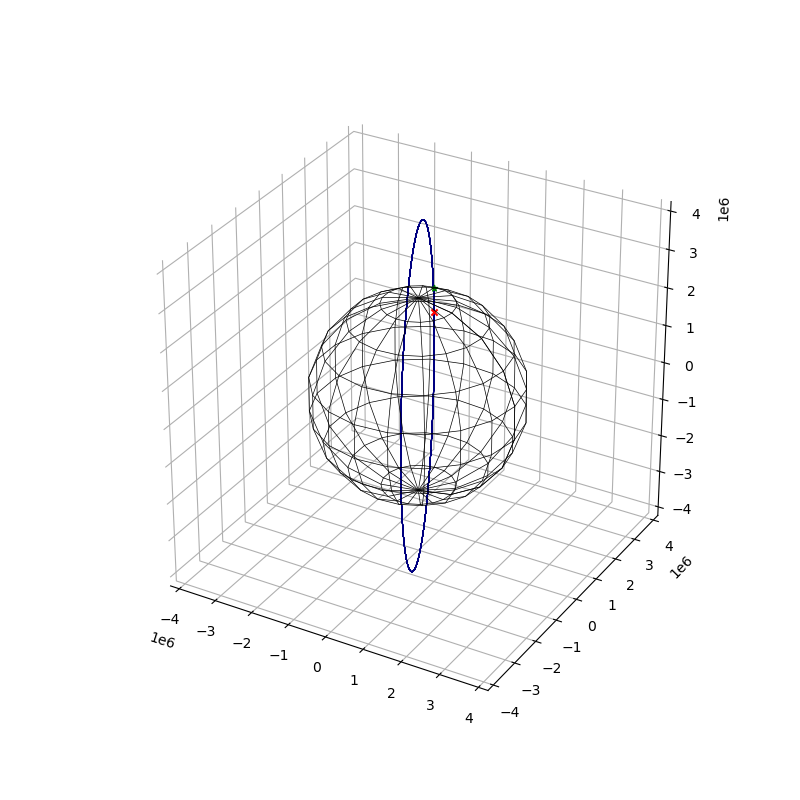

In [426]:
fig, ax = tpl.quickplot3(propout_j2.xs, propout_j2.ys, propout_j2.zs, radius=pxp.R_TITAN, n_figsize=8)

In [428]:
PERIOD_TITAN = 2*np.pi*np.sqrt(pxp.SMA_TITAN**3/pxp.MU_SATURN)
PERIOD_TITAN/86400

15.946856899173904

In [429]:
omega = 2*np.pi/PERIOD_TITAN
print(f"omega: {omega*180/np.pi} deg/s")

omega: 0.0002612845084778125 deg/s


In [430]:
rs_j2_rotating = rotate_propout(propout_j2, omega)

<IPython.core.display.Javascript object>


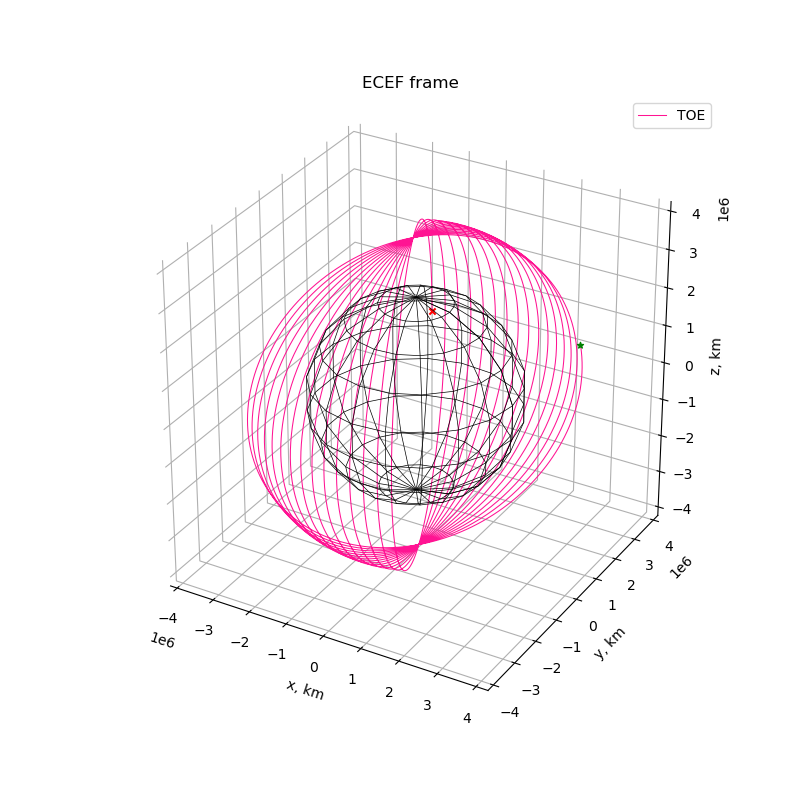

In [431]:
fig, ax = tpl.quickplot3(
    rs_j2_rotating[0,:], rs_j2_rotating[1,:], rs_j2_rotating[2,:], radius=pxp.R_TITAN, 
    c_traj="deeppink", n_figsize=8, label=f"TOE"
)

ax.set_xlabel('x, km')
ax.set_ylabel('y, km')
ax.set_zlabel('z, km')
ax.set_title("ECEF frame")
ax.legend()
#plt.savefig("./plots/ecef_toe.png")
plt.show()

In [432]:
def ecef_to_groundtracks(rs_ecef):
    """Convert coordinates in ECEF to ground tracks"""
    _, n = rs_ecef.shape
    spherical_coords = np.zeros((3,n))
    for i in range(n):
        r_vec = rs_ecef[:,i]
        spherical_coords[0,i] = np.linalg.norm(r_vec)  # radius
        # shift longitude
        long = np.arctan2(r_vec[1], r_vec[0]) 
        if long < 0:
            long = 2*np.pi + long
        spherical_coords[1,i] = long   # longitude
        spherical_coords[2,i] = np.arctan2(r_vec[2], np.linalg.norm(r_vec[0:2]))  # latitude
    return spherical_coords

In [433]:
def plot_groundtrack(longitudes, latitudes, c="navy", s=0.1, ssat=5, ax=None, label=None, convert_to_deg=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    if convert_to_deg:
        rad2deg = 180/np.pi
    else:
        rad2deg = 1
    # plot
    ax.scatter(longitudes[-1]*rad2deg, latitudes[-1]*rad2deg, label=label, c=c, marker="x", s=ssat)
    ax.scatter(longitudes*rad2deg, latitudes*rad2deg, label=None, c=c, marker=".", s=s, zorder=3)
    if ax is None:
        return fig, ax
    else:
        return _, ax

In [434]:
spherical_coord = ecef_to_groundtracks(rs_j2_rotating)

<IPython.core.display.Javascript object>


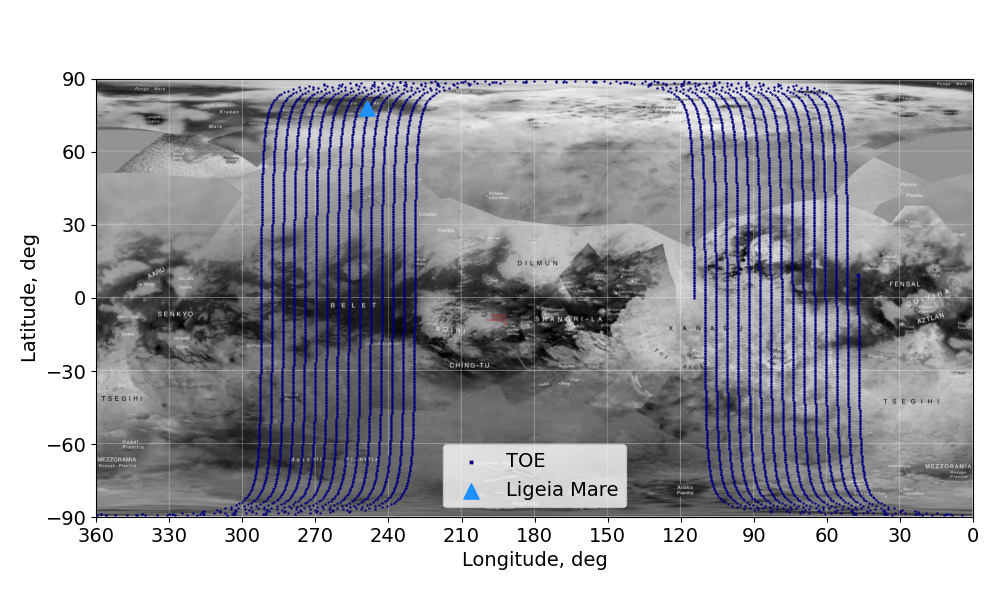

In [447]:
#cs = ['blue', 'deeppink', 'orangered', 'lime']
plt.rcParams["font.size"] = 14

fig, ax = plot_groundtrack(spherical_coord[1,:], spherical_coord[2,:], c="navy", label="TOE", s=2)
img = plt.imread("groundtrack_back_picture.png")
ax.imshow(img, extent=[0, 360, -90, 90])
ax.scatter(249, 78, marker="^", s=120, c="dodgerblue", zorder=3,label="Ligeia Mare")

ax.legend()
ax.set(xlabel="Longitude, deg", ylabel="Latitude, deg")
#plt.savefig("./plots/ground_tracks.png")
ax.set_ylim([-90, 90])
ax.set_xlim([360, 0])

ax.set_yticks([-90,-60,-30,0,30,60,90])
ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])

plt.tight_layout(rect=[0, 0.03, 1.0, 0.95]) 
plt.show()

In [448]:
plt.savefig("./plots/groundtrack_raw_3days.png")